Q R S T U V W X Y Z

In [97]:
from keras.layers import Input, Dense
from keras.models import Model

from sklearn.model_selection import train_test_split

import numpy as np

from google.colab import drive
from matplotlib import pyplot as plt
from keras.utils import np_utils


%matplotlib inline

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Visto che il dataset è in formato .obj utilizzo il modulo **pickle** di python per importarlo.

Il modulo pickle implementa un algoritmo per trasformare un oggetto arbitrario Python in un una serie di byte. 
Questo processo viene anche detto serializzazione dell'oggetto). Il flusso di byte che rappresenta l'oggetto può successivamente ricostruito per creare un nuovo oggetto con le stesse caratteristiche.

In [0]:
import pickle 

x_train = pickle.load(open("drive/My Drive/Colab Notebooks/DL-Autoencoders-experiments-on-letters/datasets/x_train.obj","rb"))
y_train = pickle.load(open("drive/My Drive/Colab Notebooks/DL-Autoencoders-experiments-on-letters/datasets/y_train.obj","rb"))
x_test = pickle.load(open("drive/My Drive/Colab Notebooks/DL-Autoencoders-experiments-on-letters/datasets/x_test.obj","rb"))

## Analisi del dataset

In [99]:
x_train.shape

(14000, 28, 28)

In [100]:
y_train.shape

(14000,)

In [101]:
from collections import Counter
count = Counter(y_train)
count

Counter({16: 1295,
         17: 1265,
         18: 1346,
         19: 1329,
         20: 1336,
         21: 1297,
         22: 1269,
         23: 1327,
         24: 1322,
         25: 1321,
         26: 893})

Il dataset di train non è particolarmente sbilanciato

In [102]:
x_test.shape


(8800, 28, 28)

Quindi ho:

*   **14.0000** matrici 28x28 che sono i dati di **train**
*   **8.800** matrici 28x28 che sono i dati di **test**



### Provo a stampare le prime 10 lettere del train set e confrontare con il target

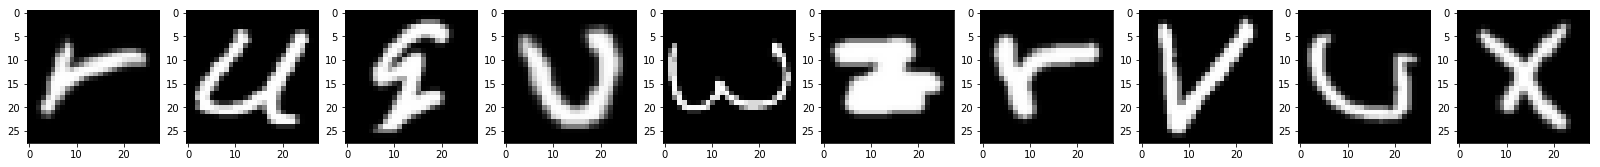

In [103]:
n = 10
plt.figure(figsize=(28, 28))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
 

**Converto** i numeri delle lettere c**he vanno da 17 a 26** in numeri che vanno da** 0 a 9**

In questo modo anche se non corrispondono più all'ordine alfabetico mi è più comodo valutarli

In [0]:


for i in range(y_train.shape[0]):
  #print(y_train[i], 17)
  y_train[i]=int(y_train[i])-16
  #print(y_train[i])


**Del train set ho anche il valore del target: che target hanno quelle che ho appena stampato?**

In [105]:
#il target è individuato dal numero della lettera (da 16 a 26)
#Quindi questa funzione mappa il numero della lettera al simbolo della lettera stessa, così mi è facile riconoscerle
def letter_number(n):
  letters=["P","Q","R","S","T","U","V","W","X","Y","Z"]
  return letters[n]

#Stampo il valore target delle lettere sopra, seguite dal corrispondente letterale
n = 10
for i in range(n):
  print(y_train[i], letter_number(y_train[i]))
 

2 R
5 U
1 Q
5 U
7 W
10 Z
2 R
6 V
5 U
8 X


Confrontanto a occhio **corrispondono**.

Ora ho un idea precisa di come sia composto il DS e posso iniziare a lavorarci.

## Reshape dei dati
Visto che il modello non può lavorare con le matrici trasformo la matrice 28z28 in un array da 784 (28*28) valori

In [106]:
print("Shape prima del reshape:")
print(x_train.shape, "Train Set")
print(x_test.shape, " Test Set\n")


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print("Shape dopo il reshape:")
print(x_train.shape, "Train Set")
print(x_test.shape, " Test Set")

Shape prima del reshape:
(14000, 28, 28) Train Set
(8800, 28, 28)  Test Set

Shape dopo il reshape:
(14000, 784) Train Set
(8800, 784)  Test Set


Ho ridotto di una dimensione

## Creo il Validation Set



In [0]:
train_data, val_data, train_target, val_target= train_test_split(x_train, y_train, test_size=0.15, random_state=42)


In [108]:
print("-> Original Train Set Shape:")
print(x_train.shape)
print(x_train.shape)
print("\n---- VALIDATION SPLIT ----\n")
print("-> Train Set Shape:")
print(train_data.shape)
print(train_target.shape)
print("-> Validation Set Shape:")
print(val_data.shape)
print(val_target.shape)


-> Original Train Set Shape:
(14000, 784)
(14000, 784)

---- VALIDATION SPLIT ----

-> Train Set Shape:
(11900, 784)
(11900,)
-> Validation Set Shape:
(2100, 784)
(2100,)


## Definisco il modello di Encoding

In [0]:
#Dimensione della rappresentazione dell'encoded.
encoding_dim = 64  

# Questo è il nostro placeholder di input
input_img = Input(shape=(784,))
# "encoded" è la rappresentazione encoded (codificata) dell'inpunt
encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)

# "decoded" è la ricostruzione (lossy) dell'input
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# Questo è il modello che mappa l'input con la sua ricostruzione
autoencoder = Model(input_img, decoded)

In [0]:
#Questo è il modello che mappa l'input alla sua rappresentazione ecoded
encoder = Model(input_img, encoded)

In [0]:
# creo un placeholder per un input encoded (32-dimensional)
encoded_input = Input(shape=(64,))
# Recupero l'ultimo livello del modello dell'autoencoder
decoder_layer_1 = autoencoder.layers[-2](encoded_input)
decoder_layer_2 = autoencoder.layers[-1](decoder_layer_1)



# creo il modello del decoder
decoder = Model(encoded_input, decoder_layer_2)

In [112]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 784)               50960     
Total params: 109,520
Trainable params: 109,520
Non-trainable params: 0
_________________________________________________________________


In [113]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1) #Imposto che le epoche si fermino quando val_loss smette di migliorare 

#note: x_train, x_train :) 
history = autoencoder.fit(train_data, train_data,
                epochs=200,
                batch_size=200,
                shuffle=True,
                validation_data=(val_data, val_data), callbacks=[early_stop])

Train on 11900 samples, validate on 2100 samples
Epoch 1/200
11900/11900 [==============================] - 2s 167us/step - loss: 0.4493 - val_loss: 0.3425
Epoch 2/200
11900/11900 [==============================] - 1s 78us/step - loss: 0.3101 - val_loss: 0.2817
Epoch 3/200
11900/11900 [==============================] - 1s 77us/step - loss: 0.2646 - val_loss: 0.2492
Epoch 4/200
11900/11900 [==============================] - 1s 79us/step - loss: 0.2354 - val_loss: 0.2240
Epoch 5/200
11900/11900 [==============================] - 1s 80us/step - loss: 0.2161 - val_loss: 0.2099
Epoch 6/200
11900/11900 [==============================] - 1s 82us/step - loss: 0.2052 - val_loss: 0.2018
Epoch 7/200
11900/11900 [==============================] - 1s 80us/step - loss: 0.1976 - val_loss: 0.1951
Epoch 8/200
11900/11900 [==============================] - 1s 79us/step - loss: 0.1915 - val_loss: 0.1896
Epoch 9/200
11900/11900 [==============================] - 1s 81us/step - loss: 0.1865 - val_loss: 0.1

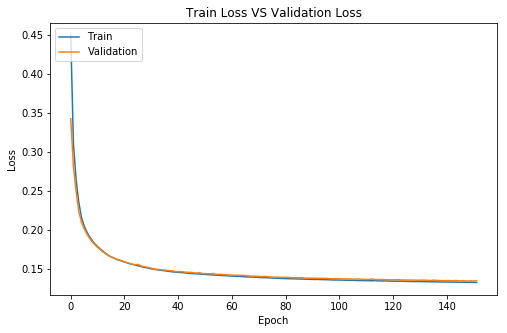

In [114]:
def plot_train_vs_validate(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title("Train Loss VS Validation Loss")
    plt.show()
    
plot_train_vs_validate(history)


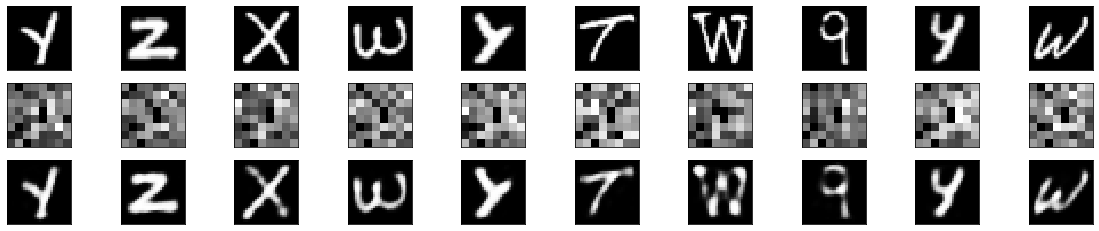

In [116]:
#eseguo le predizioni normalmente con encoder e decoder
encoded_imgs = encoder.predict(train_data)
encoded_imgs_val = encoder.predict(val_data)
encoded_imgs_test = encoder.predict(x_test)


decoded_imgs = decoder.predict(encoded_imgs)



n = 10 
plt.figure(figsize=(20, 4))

#Stampo il confrnto tra input e output
for i in range(n):
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(train_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(3, n, 2*n +i+ 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Addestro il modello sui dati di Train
### Fornendo come input le immagini dell'encoder

In [117]:
encoded_imgs.shape

(11900, 64)

In [121]:
from keras.models import Sequential
from keras.layers import Dense, Activation


model = Sequential() 
model.add(Dense(128, activation='relu',input_shape=(64,) ))
model.add(Dense(32, activation='relu' ))
model.add(Dense(11)) 
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',  
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_32 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_33 (Dense)             (None, 11)                363       
_________________________________________________________________
activation_3 (Activation)    (None, 11)                0         
Total params: 12,811
Trainable params: 12,811
Non-trainable params: 0
_________________________________________________________________


In [133]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1) #Imposto che le epoche si fermino quando val_loss smette di migliorare 

history_dieci = model.fit(encoded_imgs, train_target, validation_data=(encoded_imgs_val, val_target),
                    epochs=200, batch_size=160, callbacks=[early_stop])

Train on 11900 samples, validate on 2100 samples
Epoch 1/200
11900/11900 [==============================] - 0s 14us/step - loss: 0.0023 - acc: 0.9999 - val_loss: 0.4581 - val_acc: 0.9352
Epoch 2/200
11900/11900 [==============================] - 0s 14us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.4634 - val_acc: 0.9348
Epoch 3/200
11900/11900 [==============================] - 0s 15us/step - loss: 0.0024 - acc: 0.9999 - val_loss: 0.4539 - val_acc: 0.9362
Epoch 4/200
11900/11900 [==============================] - 0s 14us/step - loss: 0.0022 - acc: 0.9999 - val_loss: 0.4564 - val_acc: 0.9362
Epoch 5/200
11900/11900 [==============================] - 0s 14us/step - loss: 0.0022 - acc: 0.9999 - val_loss: 0.4618 - val_acc: 0.9343
Epoch 6/200
11900/11900 [==============================] - 0s 14us/step - loss: 0.0022 - acc: 0.9999 - val_loss: 0.4615 - val_acc: 0.9333
Epoch 7/200
11900/11900 [==============================] - 0s 16us/step - loss: 0.0026 - acc: 0.9998 - val_loss: 0.4563 - v

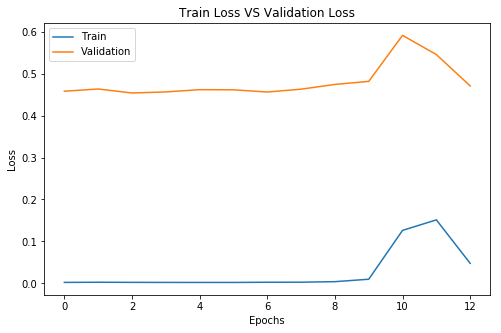

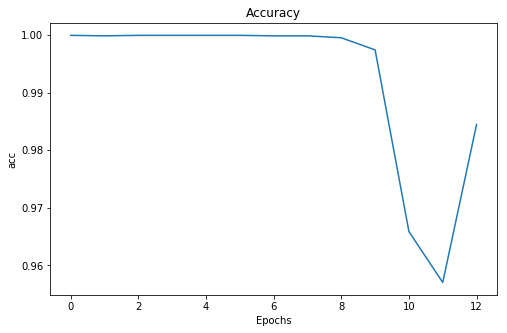

In [134]:
def plot_train_vs_validate(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title("Train Loss VS Validation Loss")
    plt.show()
    
def plot_history(network_history, index):
    plt.figure(figsize=(8,5)) 
    plt.xlabel('Epochs')
    plt.ylabel(index)
    plt.title("Accuracy")
    plt.plot(network_history.history[index])

    plt.show()
    
plot_train_vs_validate(history_dieci)
plot_history(history_dieci, 'acc')


## Predizione sul Dataset di Test


In [0]:
predictions = model.predict(encoded_imgs_test)

0.9999858 5 U


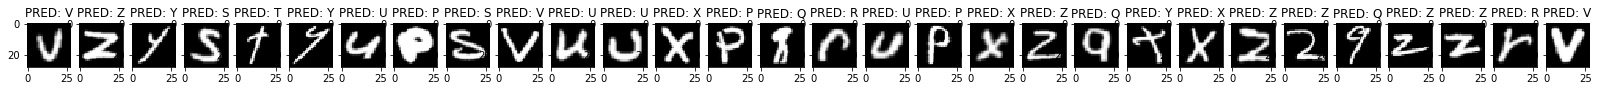

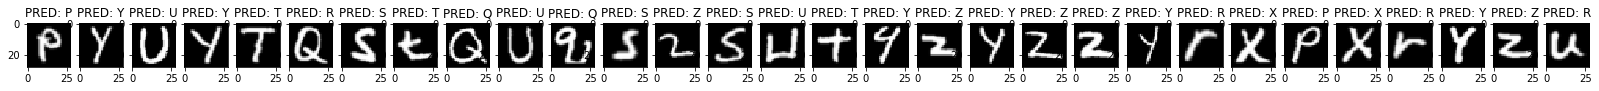

In [136]:
n = 30
plt.figure(figsize=(28, 28))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    ax.set_title("PRED: %s" %letter_number(np.argmax(predictions[i])))
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    
n = 60
plt.figure(figsize=(28, 28))
for i in range(30, n):
    ax = plt.subplot(2, n-30, i + 1)
    ax.set_title("PRED: %s" %letter_number(np.argmax(predictions[i])))
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    


k=100

highest = max(predictions[k])

#print(predictions[k])

print(highest, np.argmax(predictions[k]), letter_number(np.argmax(predictions[k])))

plt.imshow(x_test[k].reshape(28, 28))

In [0]:

with open("Fabrizio_Olivadese_820864_score2.txt", 'w') as f:
    for i in range(8800):
        f.write(str(np.argmax(predictions[i])+16))
        f.write('\n')

NameError: ignored